In [1]:
import pandas as pd 

In [2]:
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/indiana-pro-reports/indiana_PROreports.csv')

In [3]:
df2=df2[df2['projection'] == 'Frontal']

In [4]:
df2.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
2,2,2_IM-0652-1001.dcm.png,Frontal
4,3,3_IM-1384-1001.dcm.png,Frontal
6,4,4_IM-2050-1001.dcm.png,Frontal
8,5,5_IM-2117-1003002.dcm.png,Frontal


In [5]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset

import pandas as pd
from sklearn.model_selection import train_test_split

from pathlib import Path
from PIL import Image

2025-02-25 16:25:25.741989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 16:25:25.742045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 16:25:25.743728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
df1

,Unnamed: 0,uid,MeSH,Problems,image,indication,comparison,impression,findings
0,0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,Normal chest x-XXXX.,the cardiac silhouette and mediastinum size ar...
1,1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,No acute pulmonary findings.,borderline cardiomegaly. midline sternotomy xx...
2,2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,"No displaced rib fractures, pneumothorax, or p...",NaN
3,3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,1. Bullous emphysema and interstitial fibrosis...,there are diffuse bilateral interstitial and a...
4,4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,No acute cardiopulmonary abnormality.,the cardiomediastinal silhouette and pulmonary...
...,...,...,...,...,...,...,...,...,...
3846,3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",1. Interval resolution of bibasilar airspace d...,the cardiomediastinal silhouette and pulmonary...
3847,3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,Clear lungs. No acute cardiopulmonary abnormal...,the lungs are clear. heart size is normal. no ...
3848,3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"No acute findings, no evidence for active TB.","heart size within normal limits. small, nodula..."
3849,3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,Heart size is normal and the lungs are clear.,NaN


In [7]:
# import pandas as pd

# # Load the dataset (adjust the file path as needed)
# df1 = pd.read_csv('/kaggle/input/indiana-pro-reports/indiana_PROreports.csv')

# # Get unique values from the "Problems" column (dropping any missing values)
# unique_problems = df1['Problems'].dropna().unique()

# print("Unique values in 'Problems':")
# for item in unique_problems:
#     print(item)
import pandas as pd

# Load the dataset (adjust the file path as needed)
df1 = pd.read_csv('/kaggle/input/indiana-pro-reports/indiana_PROreports.csv')

# For the 'Problems' column, drop NaNs and split each entry by semicolon
problems_split = df1['Problems'].dropna().apply(lambda x: [term.strip() for term in x.split(';')])

# Flatten the list of lists into a single list of individual terms
flat_terms = [term for sublist in problems_split for term in sublist]

# Get the unique terms (sorted for readability)
unique_terms = sorted(set(flat_terms))

# Print the unique terms in the "Term: Absent" format
print("Unique individual terms in 'Problems':")
for term in unique_terms:
    print(f"{term}: Absent")


Unique individual terms in 'Problems':
Abdomen: Absent
Adipose Tissue: Absent
Airspace Disease: Absent
Aorta: Absent
Aorta, Thoracic: Absent
Aortic Aneurysm: Absent
Arthritis: Absent
Atherosclerosis: Absent
Blister: Absent
Blood Vessels: Absent
Bone Diseases, Metabolic: Absent
Bone and Bones: Absent
Breast Implants: Absent
Bronchiectasis: Absent
Bronchiolitis: Absent
Bronchitis: Absent
Bullous Emphysema: Absent
Calcified Granuloma: Absent
Calcinosis: Absent
Cardiac Shadow: Absent
Cardiomegaly: Absent
Catheters, Indwelling: Absent
Cavitation: Absent
Cervical Vertebrae: Absent
Cholelithiasis: Absent
Cicatrix: Absent
Colonic Interposition: Absent
Consolidation: Absent
Contrast Media: Absent
Costophrenic Angle: Absent
Cystic Fibrosis: Absent
Cysts: Absent
Deformity: Absent
Density: Absent
Diaphragm: Absent
Diaphragmatic Eventration: Absent
Dislocations: Absent
Emphysema: Absent
Epicardial Fat: Absent
Expansile Bone Lesions: Absent
Fibrosis: Absent
Foreign Bodies: Absent
Fractures, Bone: Ab

In [8]:
images_captions_df = pd.DataFrame({'imgs': [],
                                    'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
         
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
images_captions_df.head()

,imgs,captions
0,1_IM-0001-4001.dcm.png,the cardiac silhouette and mediastinum size ar...
1,2_IM-0652-1001.dcm.png,borderline cardiomegaly. midline sternotomy xx...
2,4_IM-2050-1001.dcm.png,there are diffuse bilateral interstitial and a...
3,5_IM-2117-1003002.dcm.png,the cardiomediastinal silhouette and pulmonary...
4,6_IM-2192-1001.dcm.png,heart size and mediastinal contour are within ...


In [9]:
print(images_captions_df)

                           imgs  \
0        1_IM-0001-4001.dcm.png   
1        2_IM-0652-1001.dcm.png   
2        4_IM-2050-1001.dcm.png   
3     5_IM-2117-1003002.dcm.png   
4        6_IM-2192-1001.dcm.png   
...                         ...   
3302  3993_IM-2044-1001.dcm.png   
3303  3994_IM-2045-2001.dcm.png   
3304  3995_IM-2046-1001.dcm.png   
3305  3996_IM-2047-1001.dcm.png   
3306  3997_IM-2048-1001.dcm.png   

                                               captions  
0     the cardiac silhouette and mediastinum size ar...  
1     borderline cardiomegaly. midline sternotomy xx...  
2     there are diffuse bilateral interstitial and a...  
3     the cardiomediastinal silhouette and pulmonary...  
4     heart size and mediastinal contour are within ...  
...                                                 ...  
3302  the heart is mildly enlarged. left hemidiaphra...  
3303  similar mild cardiomegaly. of the pulmonary va...  
3304  the cardiomediastinal silhouette and pulmonary...  

In [10]:
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p+ images_captions_df['imgs']
images_captions_df.head()

,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,the cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,borderline cardiomegaly. midline sternotomy xx...
2,/kaggle/input/chest-xrays-indiana-university/i...,there are diffuse bilateral interstitial and a...
3,/kaggle/input/chest-xrays-indiana-university/i...,the cardiomediastinal silhouette and pulmonary...
4,/kaggle/input/chest-xrays-indiana-university/i...,heart size and mediastinal contour are within ...


In [12]:
# maximum length for the captions
max_length = 384
sample = images_captions_df.iloc[99]

# sample image
image = Image.open(sample['imgs']).convert('RGB')
# sample caption
caption = sample['captions']

# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors='pt')
# apply tokenizer
outputs = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )

In [13]:
print(f"Inputs:\n{inputs}\nOutputs:\n{outputs}")

Inputs:
{'pixel_values': tensor([[[[-0.6000, -0.6314, -0.6157,  ..., -0.7882, -0.8039, -0.7882],
          [-0.6235, -0.6784, -0.6784,  ..., -0.8353, -0.8353, -0.8196],
          [-0.6392, -0.6784, -0.6863,  ..., -0.8353, -0.8275, -0.7961],
          ...,
          [-0.5529, -0.6549, -0.7255,  ..., -0.5216, -0.5373, -0.6157],
          [-0.6000, -0.6863, -0.7490,  ..., -0.1529, -0.1686, -0.2314],
          [-0.8039, -0.8510, -0.8745,  ...,  0.2000,  0.1765,  0.1294]],

         [[-0.6000, -0.6314, -0.6157,  ..., -0.7882, -0.8039, -0.7882],
          [-0.6235, -0.6784, -0.6784,  ..., -0.8353, -0.8353, -0.8196],
          [-0.6392, -0.6784, -0.6863,  ..., -0.8353, -0.8275, -0.7961],
          ...,
          [-0.5529, -0.6549, -0.7255,  ..., -0.5216, -0.5373, -0.6157],
          [-0.6000, -0.6863, -0.7490,  ..., -0.1529, -0.1686, -0.2314],
          [-0.8039, -0.8510, -0.8745,  ...,  0.2000,  0.1765,  0.1294]],

         [[-0.6000, -0.6314, -0.6157,  ..., -0.7882, -0.8039, -0.7882],
     

In [14]:
from torch.utils.data import Dataset
from PIL import Image

class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['imgs'].values
        self.captions = df['captions'].values
    
    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # store the inputs, labels, and image path in the dict we created
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        
        return inputs
    
    def __len__(self):
        return len(self.images)


In [15]:
train_df, test_df = train_test_split(images_captions_df, test_size=0.2, shuffle=True, random_state=42)

train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

In [16]:
import cv2

In [17]:
import torch
import matplotlib.pyplot as plt

In [18]:
len(test_df)

662

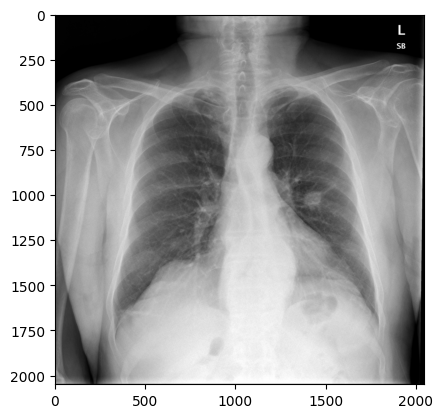

In [19]:
I=cv2.imread(test_df['imgs'].iloc[0])
plt.imshow(I)

In [20]:
len(test_ds)

662

In [21]:
out=test_ds[90]['labels']
tokenizer.decode(out, skip_special_tokens=True)

'chest. heart size normal. lungs clear. xxxx unremarkable. limited technique. right elbow and forearm. no acute fracture, dislocation or joint effusion. soft tissues unremarkable. left ankle. soft tissue xxxx around ankle. there are midfoot degenerative changes and plantar calcaneal enthesophyte. ankle mortise intact. no acute fracture or dislocation.'

In [22]:
len(test_ds[90]['labels'])

384

In [23]:
next(iter(test_ds))

{'pixel_values': tensor([[[-0.9608, -0.9686, -0.9686,  ..., -0.7020, -0.5843, -0.6000],
          [-0.9608, -0.9686, -0.9765,  ..., -0.9373, -0.8588, -0.8039],
          [-0.9608, -0.9686, -0.9765,  ..., -0.9843, -0.8980, -0.8431],
          ...,
          [ 0.0431,  0.0275,  0.0745,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.0824,  0.0980,  0.1451,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.1765,  0.2000,  0.2235,  ..., -0.9843, -1.0000, -1.0000]],
 
         [[-0.9608, -0.9686, -0.9686,  ..., -0.7020, -0.5843, -0.6000],
          [-0.9608, -0.9686, -0.9765,  ..., -0.9373, -0.8588, -0.8039],
          [-0.9608, -0.9686, -0.9765,  ..., -0.9843, -0.8980, -0.8431],
          ...,
          [ 0.0431,  0.0275,  0.0745,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.0824,  0.0980,  0.1451,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.1765,  0.2000,  0.2235,  ..., -0.9843, -1.0000, -1.0000]],
 
         [[-0.9608, -0.9686, -0.9686,  ..., -0.7020, -0.5843, -0.6000],
          [-

In [24]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint, 
    decoder_add_cross_attention=True
)

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size
model.config.num_beams = 4

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', '

In [25]:
batch = next(iter(train_ds))

model(pixel_values=batch['pixel_values'].unsqueeze(0), labels=batch['labels'].unsqueeze(0))

Seq2SeqLMOutput(loss=tensor(13.4967, grad_fn=<NllLossBackward0>), logits=tensor([[[ -43.3933,  -39.7915,  -43.0261,  ...,  -54.0470,  -54.3215,
           -42.3487],
         [ -54.6993,  -54.5678,  -58.5794,  ...,  -60.3817,  -60.4920,
           -54.4916],
         [ -85.9231,  -85.5793,  -86.7041,  ...,  -95.2366,  -94.6579,
           -86.4153],
         ...,
         [ -96.3702,  -89.4042,  -92.2575,  ..., -110.9348, -111.1339,
           -99.0356],
         [ -96.3456,  -89.3844,  -92.2373,  ..., -110.9096, -111.1077,
           -99.0121],
         [ -96.3690,  -89.4129,  -92.2663,  ..., -110.9309, -111.1292,
           -99.0299]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-7.7840e-01,  1.4246e+00,  9.9271e-01,  ..., -1.5725e+00,
           -2.5365e-01,  1.2906e+00],
          [-2.5066e+00,  2.7434e+00,  1.7806e+00,  ..., -6.2690e-01,
           -2.2915e+00,  1.8534e+00],
          [-2.9309e+00,  2.5897e+00,  7.6305e-01,  ..., -5.2303e-01,
           -2.4683e+

## Training block

In [26]:
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",  # name of the directory to store training outputs
    evaluation_strategy="epoch",           # evaluate after each epoch
    per_device_train_batch_size=8,         # batch size during training
    per_device_eval_batch_size=8,          # batch size during evaluation
    learning_rate=5e-5,
    weight_decay=0.01,                     # weight decay for AdamW optimizer
    num_train_epochs=4,                    # number of epochs to train
    save_strategy='epoch',                 # save checkpoints after each epoch
    report_to='none',                      # prevents logging to wandb, mlflow...
    gradient_accumulation_steps=4          # accumulate gradients over 4 steps
)

trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,No log,0.210805
1,No log,0.183575
2,No log,0.172356
3,No log,0.169564


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Some non-default generation parameters are set in the model

TrainOutput(global_step=328, training_loss=0.27233102844982615, metrics={'train_runtime': 2613.2637, 'train_samples_per_second': 4.049, 'train_steps_per_second': 0.126, 'total_flos': 1.8925248261767823e+18, 'train_loss': 0.27233102844982615, 'epoch': 3.9637462235649545})

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


DS:
the heart size is mildly enlarged. there is tortuosity of the thoracic aorta. no focal airspace consolidation, pleural effusions or pneumothorax. no acute bony abnormalities.
GPT2:
the cardiomediastinal silhouette and pulmonary vasculature are within normal limits for size and contour. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. there is no acute bony abnormality.


(0.0, 1.0, 0.0, 1.0)

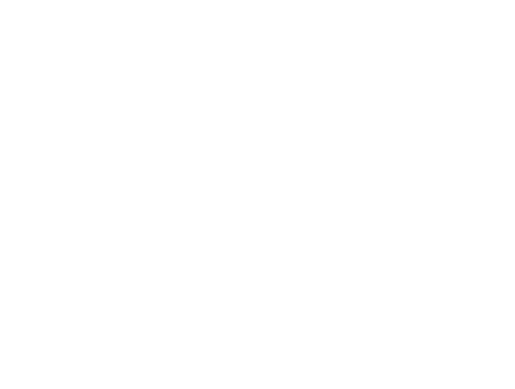

In [28]:
i=245
inputs = test_ds[i]['pixel_values']
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=max_length
        )
# convert token ids to string format
print('DS:')
print(tokenizer.decode(test_ds[i]['labels'],skip_special_tokens=True))
print('GPT2:')
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')


the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. there is no acute bony abnormality.


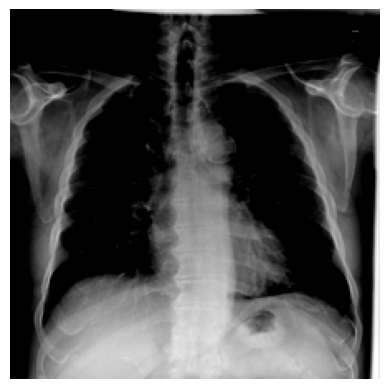

In [29]:
inputs = test_ds[43]['pixel_values']
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=max_length
        )
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

Structured Problem Summary:
Enlarged Cardiomediastinum: Absent
- Cardiomegaly: Absent
- Lung Opacity: Absent
- Lung Lesion: Absent
- Edema: Absent
- Consolidation: Absent
- Pneumonia: Absent
- Atelectasis: Absent
- Pneumothorax: Present
- Pleural Effusion: Present
- Pleural Other: Absent
- Fracture: Absent
- Support Devices: Absent
- No Finding: Absent

Generated Report:
the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. there is no acute bony abnormality.




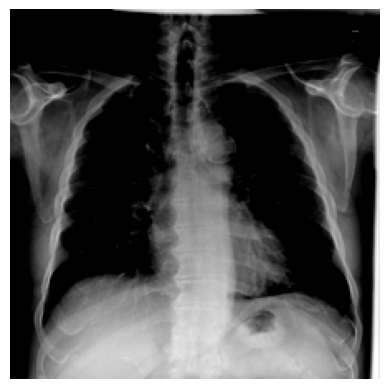

In [45]:
import torch
import matplotlib.pyplot as plt

# Choose a test sample (for example, index 43)
inputs = test_ds[43]['pixel_values']

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # If the feature extractor hasn't been applied already, you can uncomment the next line:
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # Generate the report using beam search
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'),  # Add batch dimension and move to GPU
        num_beams=4, 
        max_length=max_length
    )

# Decode the generated token IDs into text
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

# Define a curated list of problems to check for
problems = [
    "Enlarged Cardiomediastinum", 
    "Cardiomegaly", 
    "Lung Opacity", 
    "Lung Lesion", 
    "Edema", 
    "Consolidation", 
    "Pneumonia", 
    "Atelectasis", 
    "Pneumothorax", 
    "Pleural Effusion", 
    "Pleural Other", 
    "Fracture", 
    "Support Devices", 
    "No Finding"
]

# Check for each problem whether it is mentioned in the generated report
presence = {}
decoded_lower = decoded_out.lower()  # convert to lower case for case-insensitive search

for problem in problems:
    # Check if the problem term appears in the report text
    if problem.lower() in decoded_lower:
        presence[problem] = "Present"
    else:
        presence[problem] = "Absent"

# Print the structured summary in the requested format:
print("Structured Problem Summary:")
# Print the first term without a dash:
first_term = True
for prob in problems:
    status = presence.get(prob, "Absent")
    if first_term:
        print(f"{prob}: {status}")
        first_term = False
    else:
        print(f"- {prob}: {status}")

print("\nGenerated Report:")
print(decoded_out)
print("\n")

# Display the input image
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
plt.show()


Structured Problem Summary:
Enlarged Cardiomediastinum: Absent
- Cardiomegaly: Absent
- Lung Opacity: Absent
- Lung Lesion: Absent
- Edema: Absent
- Consolidation: Absent
- Pneumonia: Absent
- Atelectasis: Absent
- Pneumothorax: Present
- Pleural Effusion: Present
- Pleural Other: Absent
- Fracture: Absent
- Support Devices: Absent
- No Finding: Absent

Generated Report:
the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. there is no acute bony abnormality.




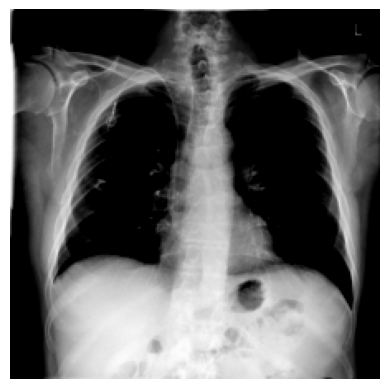

CSV file 'output_report.csv' created successfully.


In [63]:
# creating csv file 
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Choose a test sample (for example, index 43)
inputs = test_ds[41]['pixel_values']

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # If the feature extractor hasn't been applied already, you can uncomment the next line:
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # Generate the report using beam search
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'),  # Add batch dimension and move to GPU
        num_beams=4, 
        max_length=max_length
    )

# Decode the generated token IDs into text
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

# Define a curated list of problems to check for
problems = [
    "Enlarged Cardiomediastinum", 
    "Cardiomegaly", 
    "Lung Opacity", 
    "Lung Lesion", 
    "Edema", 
    "Consolidation", 
    "Pneumonia", 
    "Atelectasis", 
    "Pneumothorax", 
    "Pleural Effusion", 
    "Pleural Other", 
    "Fracture", 
    "Support Devices", 
    "No Finding"
]

# Check for each problem whether it is mentioned in the generated report
presence = {}
decoded_lower = decoded_out.lower()  # convert to lower case for case-insensitive search

for problem in problems:
    # Check if the problem term appears in the report text
    if problem.lower() in decoded_lower:
        presence[problem] = "Present"
    else:
        presence[problem] = "Absent"

# Print outputs to console for verification:
print("Structured Problem Summary:")
first_term = True
for prob in problems:
    status = presence.get(prob, "Absent")
    if first_term:
        print(f"{prob}: {status}")
        first_term = False
    else:
        print(f"- {prob}: {status}")

print("\nGenerated Report:")
print(decoded_out)
print("\n")

# Display the input image
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
plt.show()

# -------------------------------
# Create CSV file with the desired output format
# -------------------------------

output_lines = []
# First, add the Structured Problem Summary section
output_lines.append("Structured Problem Summary:")
first_term = True
for prob in problems:
    status = presence.get(prob, "Absent")
    if first_term:
        output_lines.append(f"{prob}: {status}")
        first_term = False
    else:
        output_lines.append(f"- {prob}: {status}")

# Add a blank line as a separator
output_lines.append("")

# Then, add the Generated Report section
output_lines.append("Generated Report:")
output_lines.append(decoded_out)

# Create a DataFrame with one column "Output"
df_output = pd.DataFrame(output_lines, columns=["Output"])

# Save the DataFrame as a CSV file
csv_filename = "output_report.csv"
df_output.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")


In [78]:
# row and column wise generation proper tabulor format (CSV) final 
import pandas as pd
import csv

# Assuming these variables have been computed from your inference code:
# - 'decoded_out': the generated report text
# - 'presence': a dictionary mapping each curated problem to "Present" or "Absent"
# - 'problems': the list of curated problems

# Build a dictionary with keys for each problem and the generated report.
output_dict = {prob: presence.get(prob, "Absent") for prob in problems}
output_dict["Generated Report"] = decoded_out

# Create a DataFrame with one row from the dictionary.
df_output = pd.DataFrame([output_dict])

# Save the DataFrame as a CSV file.
csv_filename = "output_report.csv"
df_output.to_csv(csv_filename, index=False, quoting=csv.QUOTE_ALL)

print(f"CSV file '{csv_filename}' created successfully.")


CSV file 'output_report.csv' created successfully.


In [64]:
#In this (CSV) is genrated which my not suit input data feed for report generation
import pandas as pd
import csv

# Build the output lines exactly as desired.
# Prepending a single quote (') to each line ensures Excel treats it as text.
output_lines = []
output_lines.append("'Structured Problem Summary:")
first_term = True
for prob in problems:
    status = presence.get(prob, "Absent")
    if first_term:
        output_lines.append(f"'{prob}: {status}")
        first_term = False
    else:
        output_lines.append(f"' {prob}: {status}")
output_lines.append("''")  # Blank line as separator with extra quote
output_lines.append("'Generated Report:")
output_lines.append(f"'{decoded_out}")

# Create a DataFrame with one column "Output"
df_output = pd.DataFrame(output_lines, columns=["Output"])

# Save the DataFrame as a CSV file with all cells quoted
csv_filename = "output_report.csv"
df_output.to_csv(csv_filename, index=False, quoting=csv.QUOTE_ALL)

print(f"CSV file '{csv_filename}' created successfully.")


CSV file 'output_report.csv' created successfully.


In [80]:
from IPython.display import HTML, display

html = HTML(f'<a href="{csv_filename}" download>Click here to download {csv_filename}</a>')
display(html)


For .txt file

Structured Problem Summary:
Enlarged Cardiomediastinum: Absent
- Cardiomegaly: Absent
- Lung Opacity: Absent
- Lung Lesion: Absent
- Edema: Absent
- Consolidation: Absent
- Pneumonia: Absent
- Atelectasis: Absent
- Pneumothorax: Present
- Pleural Effusion: Present
- Pleural Other: Absent
- Fracture: Absent
- Support Devices: Absent
- No Finding: Absent

Generated Report:
the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. there is no acute bony abnormality.




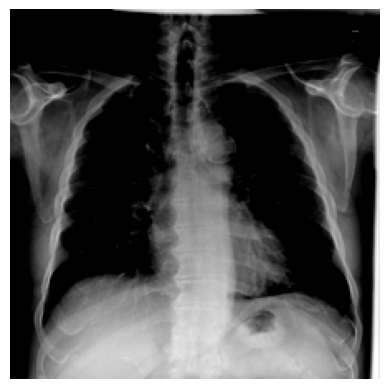

In [69]:
import torch
import matplotlib.pyplot as plt

# Choose a test sample (for example, index 43)
inputs = test_ds[43]['pixel_values']

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # If the feature extractor hasn't been applied already, you can uncomment the next line:
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # Generate the report using beam search
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'),  # Add batch dimension and move to GPU
        num_beams=4, 
        max_length=max_length
    )

# Decode the generated token IDs into text
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

# Define a curated list of problems to check for
problems = [
    "Enlarged Cardiomediastinum", 
    "Cardiomegaly", 
    "Lung Opacity", 
    "Lung Lesion", 
    "Edema", 
    "Consolidation", 
    "Pneumonia", 
    "Atelectasis", 
    "Pneumothorax", 
    "Pleural Effusion", 
    "Pleural Other", 
    "Fracture", 
    "Support Devices", 
    "No Finding"
]

# Check for each problem whether it is mentioned in the generated report
presence = {}
decoded_lower = decoded_out.lower()  # convert to lower case for case-insensitive search

for problem in problems:
    # Check if the problem term appears in the report text
    if problem.lower() in decoded_lower:
        presence[problem] = "Present"
    else:
        presence[problem] = "Absent"

# Print the structured summary in the requested format:
print("Structured Problem Summary:")
# Print the first term without a dash:
first_term = True
for prob in problems:
    status = presence.get(prob, "Absent")
    if first_term:
        print(f"{prob}: {status}")
        first_term = False
    else:
        print(f"- {prob}: {status}")

print("\nGenerated Report:")
print(decoded_out)
print("\n")

# Display the input image
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
plt.show()


In [76]:
# Save the output to a text file
with open("output_report.txt", "w") as f:
    f.write("Generated Report:\n")
    f.write(decoded_out + "\n\n")
    f.write("Structured Problem Summary:\n")
    for term, status in presence.items():
        f.write(f"{term}: {status}\n")


In [77]:
from IPython.display import HTML

# Create an HTML download link for the file
html = HTML('<a href="output_report.txt" download>Click here to download output_report.txt</a>')
display(html)


the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality.


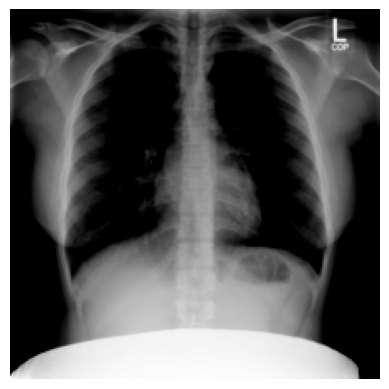

In [66]:
inputs = test_ds[89]['pixel_values']
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=max_length
        )
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/image-caption-generator/dense-caption-generator_pro.pt')

In [ ]:
len(test_ds)

## Inference Block

In [ ]:
import numpy as np

In [ ]:
from tqdm import tqdm

# Load the state dictionary from the file
state_dict = torch.load('/kaggle/input/cxr-pro-caption-generator/pytorch/cxr-pro-caption-generator-1/1/image-caption-generator_pro.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

In [ ]:
inputs = test_ds[56]['pixel_values']
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=max_length
        )
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

In [ ]:
inputs = test_ds[12]['pixel_values']
model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=max_length
        )
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)
plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));

In [ ]:
DS=[]
GPT=[]
model.eval()
for i in tqdm(range(0,250)):
    inputs = test_ds[i]['pixel_values']
    
    with torch.no_grad():
        # uncomment the below line if feature extractor is not applied to the image already
        # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

        # model prediction 
        out = model.generate(
            inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
            num_beams=4, 
            max_length=max_length
            )
    # convert token ids to string format

    y_hat=tokenizer.decode(test_ds[i]['labels'],skip_special_tokens=True)
    DS.append(y_hat)

    y_pred=tokenizer.decode(out[0], skip_special_tokens=True)
    GPT.append(y_pred)




In [ ]:
!pip install evaluate

In [ ]:
import evaluate

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=GPT, references=DS)
print(results)

In [ ]:
!pip install transformers
!pip install bert-score

In [ ]:
from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer

In [ ]:
reference =DS
candidate = GPT
scorer = BERTScorer(model_type='bert-base-uncased')
P, R, F1 = scorer.score(candidate, reference)

In [ ]:
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

In [ ]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working/image-caption-generator'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

In [ ]:
import spacy
from collections import defaultdict
from tqdm import tqdm

# Load the SpaCy model for English
nlp = spacy.load("en_core_web_sm")

# Labels and their synonyms
labels = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity",
    "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis",
    "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture",
    "Support Devices", "No Finding"
]

label_synonyms = {
    "Enlarged Cardiomediastinum": ["cardiomediastinal enlargements", "cardiomediastinal enlargement", "enlargement of the cardiac silhouette", "shift of the mediastinal structures"],
    "Cardiomegaly": ["enlarged hearts", "enlarged heart", "continued enlargement of the cardiac silhouette", "moderate cardiomegaly has worsened", "heart size is normal"],
    "Lung Opacity": ["lung densities", "lung density", "pulmonary opacities", "pulmonary opacity"],
    "Lung Lesion": ["pulmonary lesions", "pulmonary lesion"],
    "Edema": ["fluid retentions", "fluid retention", "pulmonary vascular congestion", "vascular engorgement", "cephalized vasculature consistent with pulmonary venous hypertension"],
    "Consolidation": ["pulmonary consolidations", "pulmonary consolidation", "air-space opacity", "lobar opacity", "air-space disease", "alveolar filling", "pulmonary dense area", "lung solidification", "consolidation"],
    "Pneumonia": ["lung infections", "inflammatory lung conditions", "lung infection", "inflammatory lung condition", "no evidence of pneumonia"],
    "Atelectasis": ["partial lung collapses", "lung collapses", "partial lung collapse", "lung collapse", "bibasilar atelectatic changes persist", "mild left basal atelectasis"],
    "Pneumothorax": ["collapsed lungs", "air in the chest cavities", "collapsed lung", "air in the chest cavity", "no definite pneumothorax is seen"],
    "Pleural Effusion": ["fluid in the chest cavities", "pleural fluids", "fluid in the chest cavity", "pleural fluid", "pleural thickening", "pleural effusions", "moderate right and small left pleural effusions have increased"],
    "Pleural Other": ["other pleural abnormalities", "abnormalities in the chest cavities", "other pleural abnormality", "abnormalities in the chest cavity"],
    "Fracture": ["bone breaks", "bone fractures", "bone break"],
    "Support Devices": ["medical devices", "right PIC catheter", "central catheter", "endotracheal tube", "nasogastric tube terminating in the fundus of the stomach", "right pigtail catheter", "right pacemaker"],
    "No Finding": ["normal", "lungs are clear", "lungs are grossly clear"]
}

# Function to extract independent clauses
def extract_clauses(sent):
    doc = nlp(sent)
    clauses = []
    for token in doc:
        if token.dep_ == "ROOT":
            clause = " ".join([t.text for t in token.subtree])
            clauses.append(clause)
    return clauses

# Function to extract sentences or independent clauses regarding consolidation
def extract_observations(reports):
    observations = []

    for report in tqdm(reports):
        try:
            doc = nlp(report)
        except Exception as e:
            print(f"Error processing report: {report}")
            print(f"Error details: {e}")
            observations.append("No relevant information")
            continue

        report_info = defaultdict(str)
        for sent in doc.sents:
            for label in labels:
                if label.lower() in sent.text.lower() or any(synonym in sent.text.lower() for synonym in label_synonyms.get(label, [])):
                    # Try to extract independent clauses
                    clauses = extract_clauses(sent.text)
                    if clauses:
                        report_info[label] += " ".join(clauses) + " "
                    else:
                        report_info[label] += sent.text + " "

        observations.append({label: report_info[label].strip() or "No relevant information" for label in labels})

    return observations

# Provided reports
reports = [
    "the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality.",
    "the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. the lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. there are no acute bony findings."
]

# Process the reports
result = extract_observations(reports)

# Print the final list of results
for i, res in enumerate(result):
    print(f"Report {i+1} Observations:")
    for label, observation in res.items():
        print(f"  - {label}: {observation}")
    print("\n")
